In [72]:
import os
import cv2
import numpy as np

def load_images_and_coordinates(root_folder):
    images = []
    coordinates = []

    # Loop through all folders in the root folder
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            folder_coordinates = []  # Store coordinates for this folder
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(folder_path, filename)
                    if os.path.getsize(image_path) < 10240:
                        print(f"Image '{image_path}' is too small, remove.")
                        os.remove(image_path)
                        continue

                    # Attempt to load the image
                    image = cv2.imread(image_path)
                    if image is None:
                        #print(f"Error loading image '{image_path}'. Skipping.")
                        continue

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (224, 224))
                    image_float = image.astype(np.float32) / 255.0

                    # Extract latitude and longitude from filename
                    lat_str, lon_str = filename[:-4].split(',')
                    latitude = float(lat_str)
                    longitude = float(lon_str)
                    
                    folder_coordinates.append((latitude, longitude))

                    images.append(image_float)

            # Calculate mean and std of coordinates for this folder
            folder_coordinates = np.array(folder_coordinates)
            if len(folder_coordinates) >0:
                folder_mean = np.mean(folder_coordinates, axis=0)
                folder_std = np.std(folder_coordinates, axis=0)
                print(f"Folder '{folder_name}': Mean coordinates:", folder_mean)
                print(f"Folder '{folder_name}': Std coordinates:", folder_std)
                coordinates.extend(folder_coordinates)

    images = np.array(images)
    coordinates = np.array(coordinates)

    return images, coordinates

folder_path = "C:\\Users\\lluka\\Downloads\\images"
train_images, train_coordinates = load_images_and_coordinates(folder_path)


Folder 'Aix-en-Provence': Mean coordinates: [43.52851794  5.42445838]
Folder 'Aix-en-Provence': Std coordinates: [0.02976261 0.03261333]
Folder 'Amiens': Mean coordinates: [49.89780099  2.28777525]
Folder 'Amiens': Std coordinates: [0.01693986 0.02215536]
Folder 'Antony': Mean coordinates: [48.75170062  2.30071046]
Folder 'Antony': Std coordinates: [0.01089238 0.01073053]
Folder 'Argenteuil': Mean coordinates: [48.94921651  2.24404501]
Folder 'Argenteuil': Std coordinates: [0.00779441 0.01879839]
Folder 'Aubervilliers': Mean coordinates: [48.91229434  2.38447316]
Folder 'Aubervilliers': Std coordinates: [0.00488745 0.01136567]
Folder 'Aulnay-sous-Bois': Mean coordinates: [48.94147859  2.49421813]
Folder 'Aulnay-sous-Bois': Std coordinates: [0.01289121 0.01149808]
Folder 'Avignon': Mean coordinates: [43.93140764  4.83441204]
Folder 'Avignon': Std coordinates: [0.01585903 0.03914966]
Folder 'Beauvais': Mean coordinates: [49.43389128  2.09504671]
Folder 'Beauvais': Std coordinates: [0.013

In [73]:
mean_latitude = np.mean(train_coordinates[:, 0])
std_latitude = np.std(train_coordinates[:, 0])

mean_longitude = np.mean(train_coordinates[:, 1])
std_longitude = np.std(train_coordinates[:, 1])

train_coordinates = np.array([
    ((latitude - mean_latitude) / std_latitude, (longitude - mean_longitude) / std_longitude)
    for latitude, longitude in train_coordinates
])

In [80]:
print(mean_latitude)
print(std_latitude)
print()
print(mean_longitude)
print(std_longitude)

47.132558703312604
2.4576403264415903

3.0905691083642335
1.6186796578617892


In [75]:
from sklearn.model_selection import train_test_split

def split_train_val_data(images, coordinates, val_size=0.2, random_state=None):
    train_images, val_images, train_coordinates, val_coordinates = train_test_split(
        images, coordinates, test_size=val_size, random_state=random_state)
    return train_images, val_images, train_coordinates, val_coordinates

# Example usage
val_size = 0.2  # Proportion of data to use for validation
random_state = 1  # Set a random seed for reproducibility

train_images, val_images, train_coordinates, val_coordinates = split_train_val_data(train_images, train_coordinates, val_size, random_state)

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load pre-trained model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

# Build the top layers for your specific task
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  # Output layer with 2 units for latitude and longitude
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model with early stopping
#history = model.fit(train_images, train_coordinates, epochs=40, validation_data=(val_images, val_coordinates),
 #                   callbacks=[early_stopping])
history = model.fit(train_images, train_coordinates, epochs=30, validation_data=(val_images, val_coordinates))

# Save the trained model
save_model(model, "C:\\Users\\lluka\\Downloads\\new_model")

Epoch 1/30
254/254 [==============================] - 1501s 6s/step - loss: 1.0104 - val_loss: 0.9855
Epoch 2/30
254/254 [==============================] - 1342s 5s/step - loss: 0.9730 - val_loss: 0.9795
Epoch 3/30
254/254 [==============================] - 1434s 6s/step - loss: 0.9676 - val_loss: 0.9794
Epoch 4/30
254/254 [==============================] - 1310s 5s/step - loss: 0.9651 - val_loss: 0.9760
Epoch 5/30
254/254 [==============================] - 1424s 6s/step - loss: 0.9616 - val_loss: 0.9774
Epoch 6/30
254/254 [==============================] - 1267s 5s/step - loss: 0.9553 - val_loss: 0.9695
Epoch 7/30
254/254 [==============================] - 1244s 5s/step - loss: 0.9567 - val_loss: 0.9780
Epoch 8/30
254/254 [==============================] - 1366s 5s/step - loss: 0.9511 - val_loss: 0.9781
Epoch 9/30
254/254 [==============================] - 1321s 5s/step - loss: 0.9508 - val_loss: 0.9684
Epoch 10/30
254/254 [==============================] - 1436s 6s/step - loss: 0.942

INFO:tensorflow:Assets written to: C:\Users\lluka\Downloads\model\assets


INFO:tensorflow:Assets written to: C:\Users\lluka\Downloads\model\assets


In [86]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "C:\\Users\\lluka\\Downloads\\new_model"
loaded_model = load_model(model_path)

# Path to the validation images folder
validation_folder = "C:\\Users\\lluka\\Downloads\\validation2"

In [105]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(train_images, train_coordinates, epochs=3, validation_data=(val_images, val_coordinates), batch_size = 200)
save_model(model, "C:\\Users\\lluka\\Downloads\\new_model")
model_path = "C:\\Users\\lluka\\Downloads\\new_model"
loaded_model = load_model(model_path)

Epoch 1/3
 1/41 [..............................] - ETA: 1:17:01 - loss: 1.0365

KeyboardInterrupt: 

1/1 [==============================] - 6s 6s/step
[[ 8.16719  -9.472898]]


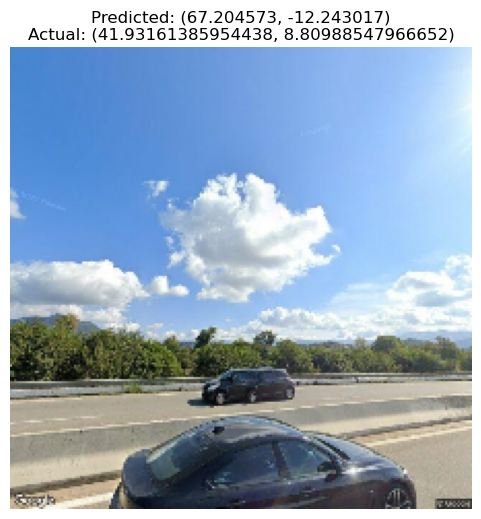

1/1 [==============================] - 2s 2s/step
[[ 0.00520328 -0.01083257]]


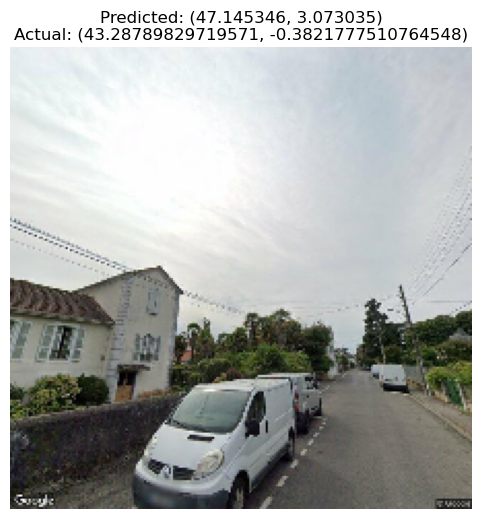

1/1 [==============================] - 2s 2s/step
[[ 0.06520675 -0.52337193]]


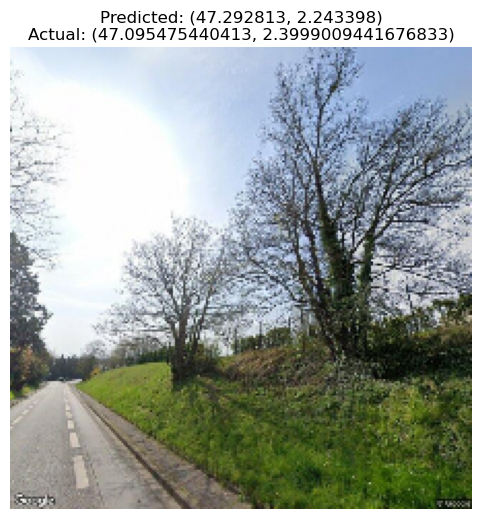

1/1 [==============================] - 2s 2s/step
[[ 0.43264928 -0.34040126]]


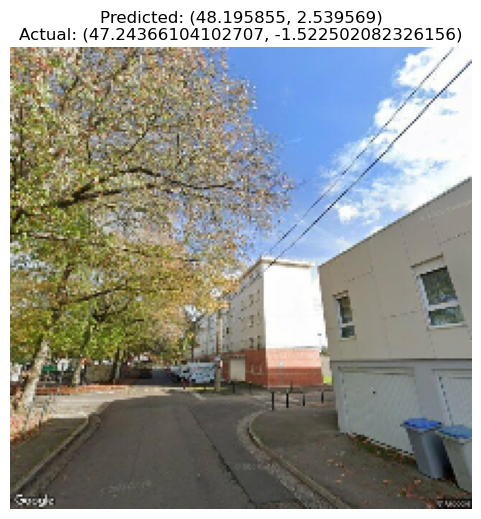

1/1 [==============================] - 1s 1s/step
[[ 1.0398458 -1.3587855]]


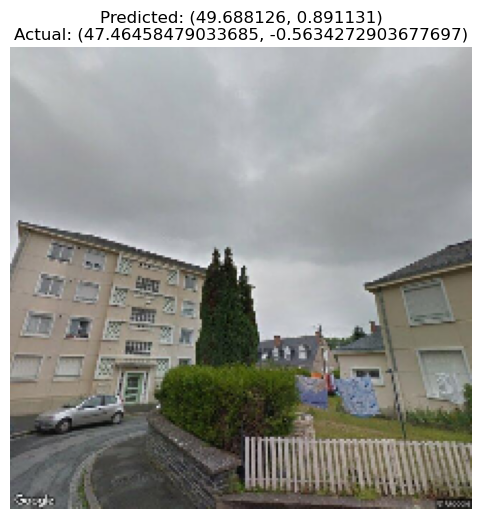

1/1 [==============================] - 2s 2s/step
[[ 1.7798867 -1.3644563]]


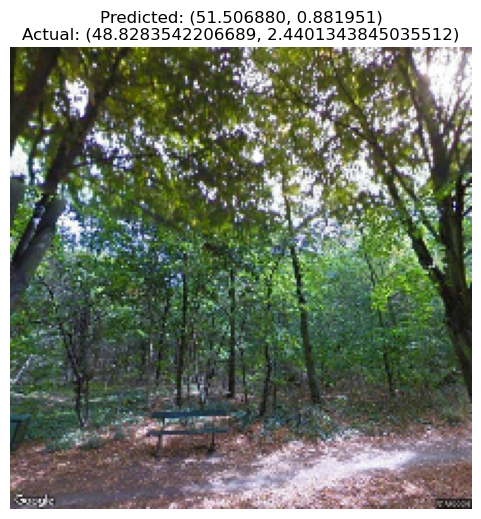

1/1 [==============================] - 2s 2s/step
[[ 0.05603125 -0.10780311]]


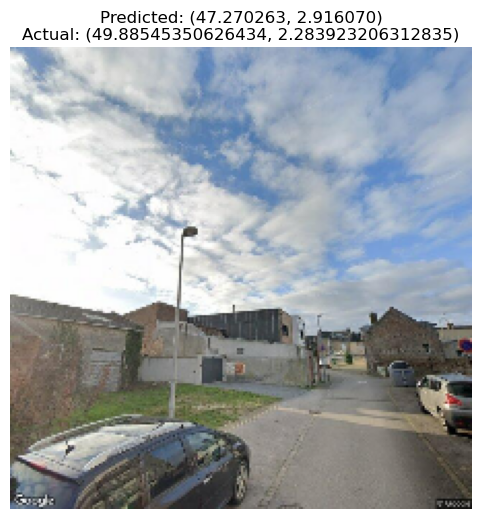

70.16877381006586


In [103]:
sum = 0
for filename in os.listdir(validation_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(validation_folder, filename)
        
        lat_str, lon_str = filename[:-4].split(',')
        latitude = float(lat_str)
        longitude = float(lon_str)
        
        # Load and preprocess the validation image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))
        
        image_float = image.astype(np.float32)
        image_float /= 255.0

        # Make a prediction using the loaded model
        prediction = loaded_model.predict(np.expand_dims(image, axis=0))
        print(prediction)
        # Extract predicted latitude and longitude
        predicted_latitude, predicted_longitude = prediction[0]
        predicted_latitude = predicted_latitude*std_latitude+mean_latitude
        predicted_longitude = predicted_longitude*std_longitude+mean_longitude
        sum += abs(predicted_latitude-latitude) + abs(predicted_longitude-longitude)
        
        # Display the image with predicted and actual coordinates
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Predicted: ({predicted_latitude:.6f}, {predicted_longitude:.6f})\nActual: ({latitude}, {longitude})")
        plt.axis('off')
        plt.show()
print(sum)